# Combined Mann Whitney U Analysis of All Networks
The Mann Whitney U Test is used to check if there is a difference between two independent groups. A normal distribution is not required for the data because the test uses a rank-sum to calculate the difference between each group.

- *Null Hypothesis:* in the population, the sum of ranks in the two groups does not differ (the groups are the same when both rank sums are equal)

- *Alternative Hypothesis:* the sum of the ranks in the two groups differ (the groups are different when the rank sums are unequal)

The p-value indicates the confidence with which we can say that two groups are similar. A test returning a p-value greater than 0.05 means that we cannot reject the null hypothesis—as the test found both groups to be significantly similar. When the p-value is less than the significance level, the null hypothesis *can* be rejected (we can infer that the two groups are different).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

%load_ext lab_black

In [2]:
# Load all networks
NETWORKKINDS = [
    "complete",
    "cycle",
    "random",
    "star",
    "wattsstrogatz",
    "barabasialbert",
]

results = {}
for kind in NETWORKKINDS:
    results[kind] = pd.read_csv(f"data/{kind}.csv")

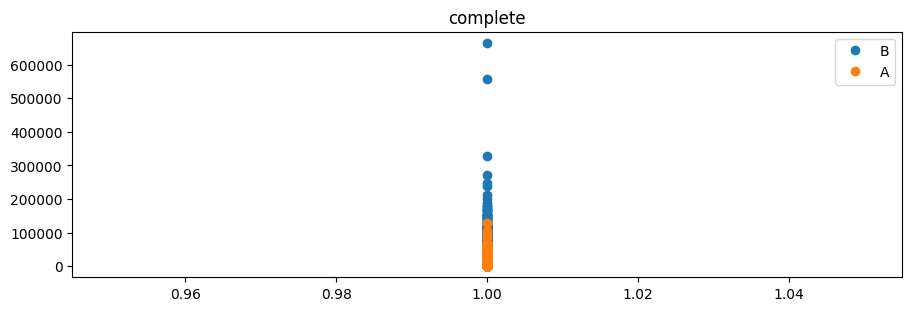

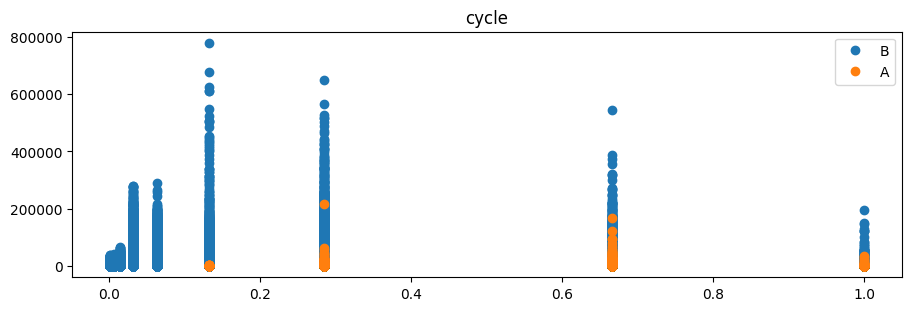

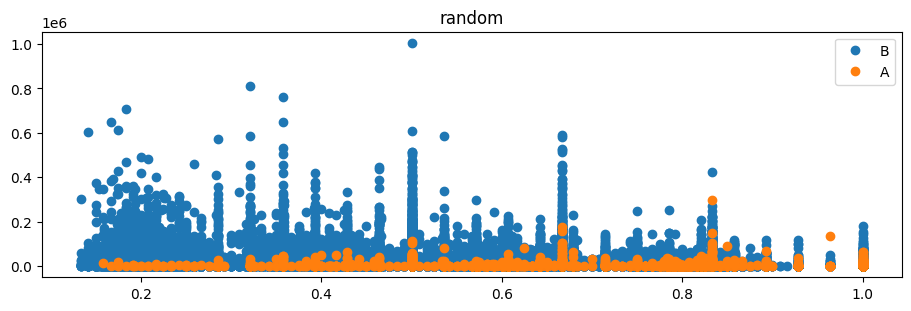

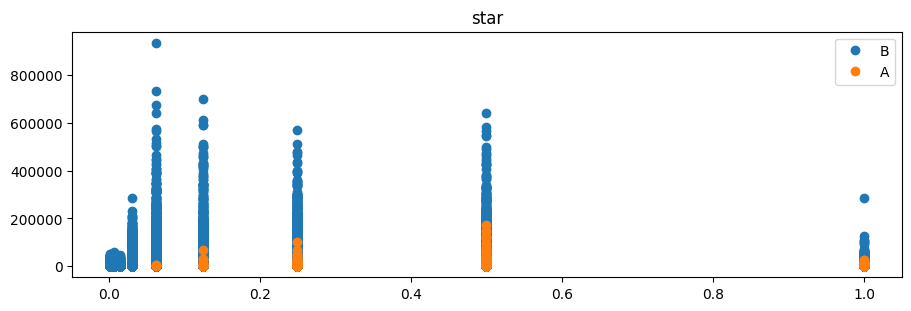

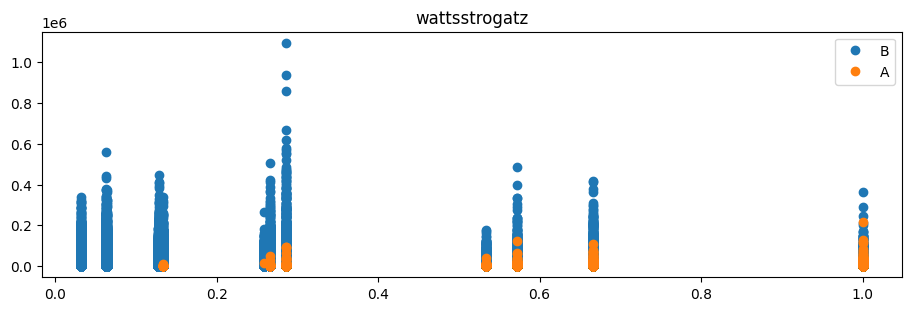

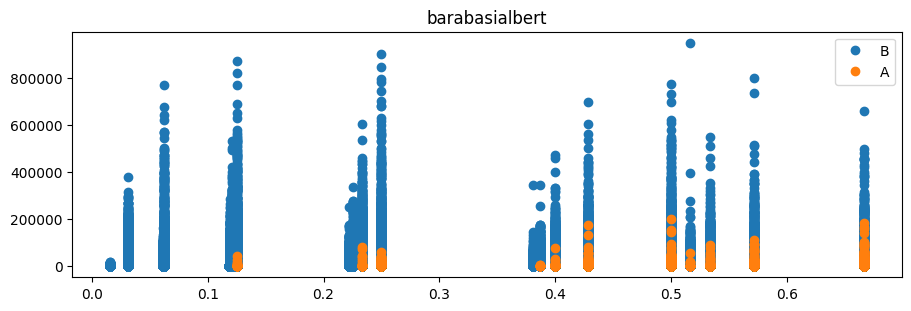

In [3]:
for kind in NETWORKKINDS:
    fig, ax = plt.subplots(figsize=(9, 3), layout="constrained")

    b = results[kind].query("action == 'B'")
    ax.plot(b.density, b.steps, marker="o", linestyle="", label="B")

    a = results[kind].query("action == 'A'")
    ax.plot(a.density, a.steps, marker="o", linestyle="", label="A")

    plt.title(kind)
    ax.legend()

## Mann-Whitney Test
First we are going to take the networks with single densities per size (complete, cycle, star) and compare them against each other and networks with mutliple densities (Watts-Strogatz and Barbasi-Albert) at each size, trials and epsilon. Second, we are going to take each Watts-Strogatz network and Compare it to each type of Barabasi-Albert network.

In [6]:
# Dataframe to store mann whitneyu results
mwu_results = pd.DataFrame()

# Networks with single densities
networks = ["complete", "cycle", "star"]

for idx, kind in enumerate(networks):
    network = results[kind].query("action != 'A'").copy()

    # Group networks by network size
    for size_name, size_group in network.groupby("size"):
        # Group by trails size
        for trials_name, trials_group in size_group.groupby("trials"):
            # Group by epsilon
            for eps_name, eps_group in trials_group.groupby("epsilon"):
                # Get other network types after the current network type, excluding itself
                for test_net_kind in networks[idx + 1 :]:
                    # Get matching data from other networksh
                    test_data = (
                        results[test_net_kind]
                        .query(
                            "action != 'A' &"
                            "size == @size_name &"
                            "trials == @trials_name &"
                            "epsilon == @eps_name"
                        )
                        .copy()
                    )

                    # If we have steps for both the current network and a network to test against run the test
                    if len(eps_group["steps"]) > 0 and len(test_data["steps"]) > 0:
                        # Calculate Mann Whitney U Test
                        stat, pvalue = stats.mannwhitneyu(
                            eps_group["steps"], test_data["steps"]
                        )

                        result_row = pd.DataFrame(
                            {
                                "network": [kind],
                                "size": [size_name],
                                "trials": [trials_name],
                                "epsilon": [eps_name],
                                "density": [eps_group["density"].iloc[0]],
                                "count": [len(eps_group)],
                                "mean_steps": [np.mean(eps_group["steps"])],
                                "compared_network": [test_net_kind],
                                "compared_density": [test_data["density"].iloc[0]],
                                "compared_count": [len(test_data)],
                                "compared_mean_steps": [np.mean(test_data["steps"])],
                                "stat": [stat],
                                "pvalue": [pvalue],
                            }
                        )

                        # Append to results dataframe
                        mwu_results = pd.concat(
                            [mwu_results, result_row], ignore_index=True
                        )

                # Networks to directly compare (where there are multiple densities per size)
                direct_comparisons = ["wattsstrogatz", "barabasialbert"]

                for direct_net_kind in direct_comparisons:
                    # Compare current network with direct network comparison
                    test_data = (
                        results[direct_net_kind]
                        .query(
                            "action != 'A' &"
                            "size == @size_name &"
                            "trials == @trials_name &"
                            "epsilon == @eps_name"
                        )
                        .copy()
                    )

                    # For each denisity in the network size run the test
                    for direct_name, direct_group in test_data.groupby("density"):
                        if (
                            len(eps_group["steps"]) > 0
                            and len(direct_group["steps"]) > 0
                        ):
                            # Calculate Mann Whitney U Test
                            stat, pvalue = stats.mannwhitneyu(
                                eps_group["steps"], direct_group["steps"]
                            )

                            result_row = pd.DataFrame(
                                {
                                    "network": [kind],
                                    "size": [size_name],
                                    "trials": [trials_name],
                                    "epsilon": [eps_name],
                                    "density": [eps_group["density"].iloc[0]],
                                    "count": [len(eps_group)],
                                    "mean_steps": [np.mean(eps_group["steps"])],
                                    "compared_network": [direct_net_kind],
                                    "compared_density": [direct_name],
                                    "compared_count": [len(direct_group)],
                                    "compared_mean_steps": [
                                        np.mean(direct_group["steps"])
                                    ],
                                    "stat": [stat],
                                    "pvalue": [pvalue],
                                }
                            )

                            # Append to results dataframe
                            mwu_results = pd.concat(
                                [mwu_results, result_row], ignore_index=True
                            )


# Compare Watts Strogatz with Barabasi Albert Networks at each density
network = results["wattsstrogatz"].query("action != 'A'").copy()

# Group networks by network size
for size_name, size_group in network.groupby("size"):
    # Group by trails size
    for trials_name, trials_group in size_group.groupby("trials"):
        # Group by epsilon
        for eps_name, eps_group in trials_group.groupby("epsilon"):
            # Group by density
            for den_name, den_group in eps_group.groupby("density"):
                # Get matching data from Barabasi Albert Networks
                test_data = (
                    results["barabasialbert"]
                    .query(
                        "action != 'A' &"
                        "size == @size_name &"
                        "trials == @trials_name &"
                        "epsilon == @eps_name"
                    )
                    .copy()
                )

                # Group test data by density
                for test_den_name, test_den_group in test_data.groupby("density"):

                    # If we have steps for both the current network and a network to test against run the test
                    if len(den_group["steps"]) > 0 and len(test_den_group["steps"]) > 0:
                        # Calculate Mann Whitney U Test
                        stat, pvalue = stats.mannwhitneyu(
                            den_group["steps"], test_den_group["steps"]
                        )

                        result_row = pd.DataFrame(
                            {
                                "network": ["wattsstrogatz"],
                                "size": [size_name],
                                "trials": [trials_name],
                                "epsilon": [eps_name],
                                "density": [den_name],
                                "count": [len(den_group)],
                                "mean_steps": [np.mean(den_group["steps"])],
                                "compared_network": ["barabasialbert"],
                                "compared_density": [test_den_name],
                                "compared_count": [len(test_den_group)],
                                "compared_mean_steps": [
                                    np.mean(test_den_group["steps"])
                                ],
                                "stat": [stat],
                                "pvalue": [pvalue],
                            }
                        )

                        # Append to results dataframe
                        mwu_results = pd.concat(
                            [mwu_results, result_row], ignore_index=True
                        )

In [4]:
mwu_results.to_csv('mannwhitney_test.csv')

In [7]:
mwu_results.query("pvalue > 0.05")

,network,size,trials,epsilon,density,count,mean_steps,compared_network,compared_density,compared_count,compared_mean_steps,stat,pvalue
0,complete,2,8,0.001,1.000000,41,39853.097561,cycle,1.000000,56,49432.017857,975.0,2.077634e-01
1,complete,2,8,0.001,1.000000,41,39853.097561,star,1.000000,56,47407.714286,979.0,2.184994e-01
2,complete,2,8,0.010,1.000000,52,370.769231,cycle,1.000000,46,459.478261,959.0,9.226219e-02
3,complete,2,8,0.010,1.000000,52,370.769231,star,1.000000,49,536.938776,943.0,2.471638e-02
4,complete,2,8,0.100,1.000000,63,5.142857,cycle,1.000000,63,6.301587,1731.0,2.135394e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,wattsstrogatz,64,256,0.008,0.126984,400,21.240000,barabasialbert,0.031250,500,116.088000,3.0,7.157227e-147
3236,wattsstrogatz,64,256,0.008,0.126984,400,21.240000,barabasialbert,0.061508,500,56.202000,1787.5,9.253253e-142
3237,wattsstrogatz,64,256,0.008,0.126984,400,21.240000,barabasialbert,0.119048,500,27.972000,51150.0,1.692752e-36
3238,wattsstrogatz,64,256,0.008,0.126984,400,21.240000,barabasialbert,0.222222,500,16.178000,151196.0,5.897360e-40
